In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [39]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [40]:
array_shape = (4,4)
telescope_number = np.prod(array_shape)
telescope_array = np.arange(telescope_number).reshape(array_shape)
tele_pos = [np.array(np.unravel_index(i, array_shape)) for i in range(telescope_number)]

In [41]:
def get_baseline_key(i1, i2, shape=array_shape):
    p1 = np.array(np.unravel_index(i1, shape))
    p2 = np.array(np.unravel_index(i2, shape))
    pos_diff = p1 - p2
    sign = np.product(pos_diff)
    if sign > 0:
        key = tuple(np.abs(pos_diff))
    else:
        key = tuple((np.abs(pos_diff[0]), -1*np.abs(pos_diff[1])))
    return key

In [42]:
def get_num_baselines(tele_num=telescope_number):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*tele_num - 2*np.sqrt(tele_num)
    return int(N_bases)

In [43]:
def get_baselines_np(tele_num=telescope_number):
    base_size = get_num_baselines(tele_num)
#     redundant_baselines = sparse.dok_matrix((base_size, tele_num, tele_num))
    redundant_baselines = np.zeros((base_size, tele_num, tele_num))
    baseline_indx = []
    for i in range(tele_num):
        for k in range(tele_num):
            if i==k:
                continue
            key = get_baseline_key(i,k)
            if key in baseline_indx:
                red_indx = baseline_indx.index(key)
                redundant_baselines[red_indx][i,k] = 1
            else:
                baseline_indx.append(key)
                redundant_baselines[len(baseline_indx)-1][i,k] = 1
    return redundant_baselines, baseline_indx

In [44]:
redundant_baselines, baseline_indx = get_baselines_np()
n_bases = get_num_baselines(telescope_number)

In [45]:
rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)

In [46]:
npcb = np.vectorize(pow)

In [47]:
def make_gains(tele_num=telescope_number):
    gain_amp = np.abs(np.random.normal(1, .3, tele_num))
    gain_phase = rand_phases(tele_num)
    tgain = gain_amp*np.exp(1j*gain_phase)
    return tgain, gain_phase

In [48]:
def make_visibilities(tele_num=telescope_number):
    n_bases = get_num_baselines(telescope_number)
    sky_phase = rand_phases(n_bases)
    correl_sky = np.random.normal(3, .8, n_bases)*np.exp(1j*sky_phase)
    return correl_sky, sky_phase

In [53]:
def make_uv_points(tg, va, tele_num=telescope_number):
    observation_baselines = np.zeros((tele_num, tele_num), dtype=np.complex128)
    unsym_noise = np.random.normal(.01, .005, (tele_num, tele_num))*np.exp(1j*rand_phases((tele_num, tele_num)))
    noise_matrix = (unsym_noise + unsym_noise.T)*.5
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            key = get_baseline_key(i, k)
            red_indx = baseline_indx.index(key)
            if i < k:
                vaterm = va[red_indx]
            else:
                vaterm = np.conj(va[red_indx])
            sig = tg[i]*np.conj(tg[k])*vaterm
            noise = noise_matrix[i,k]
            observation_baselines[i,k] = sig+noise
    return observation_baselines, noise_matrix

In [54]:
tgain, gain_phase = make_gains()
valpha, v_phase = make_visibilities()

In [55]:
observation_baselines, noises = make_uv_points(tgain, valpha)

In [56]:
snr = np.mean(np.abs(valpha)/np.mean(np.abs(noises)))
print("SNR is %f" % snr)

SNR is 460.003623


In [159]:
gain_perturb = np.random.normal(.1,.02,telescope_number)*np.exp(1j*rand_phases(telescope_number))
va_perturb = np.random.normal(.4,.2,n_bases)*np.exp(1j*rand_phases(n_bases))

In [160]:
iter_max = 400
delta = .25
eps = 1e-5

In [161]:
# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
# g0 = 1*np.exp(1j*rand_phases(telescope_number))
# g0 = 1*np.exp(1j*gain_phase)
g0 = tgain + gain_perturb
# v0 = 3*np.exp(1j*rand_phases(n_bases))
v0 = valpha + va_perturb

In [162]:
garr = g0
varr = v0
y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
w_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)+16
ratio = np.zeros(iter_max)
score = np.zeros(iter_max)
chisqr = np.zeros(iter_max)

In [163]:
for n in tqdm(range(iter_max)):
    oldx = np.concatenate((garr, varr))
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            key = get_baseline_key(i, k)
            red_indx = baseline_indx.index(key)
            if i < k:
                vaterm = varr[red_indx]
            else:
                vaterm = np.conj(varr[red_indx])
                
            sig = garr[i]*np.conjugate(garr[k])*vaterm
            y_ij[i,k] = sig
#             w_ij[i,k] = (sig**2)
            w_ij[i,k] = 16
#     gprime = garr*npcb(((w_ij*observation_baselines)/y_ij).sum(axis=1)/(w_ij.sum(axis=1)), 1/3)
    gdiv = np.divide(w_ij*observation_baselines, y_ij, out=np.zeros_like(w_ij), where=(y_ij!=0))
    gprime = garr * npcb(gdiv.sum(axis=1)/(w_ij.sum(axis=1)), 2/3)
    garr = (1 - delta)*garr + delta*gprime
    
    vprime = np.zeros(n_bases, dtype=np.complex128)
    for i in range(n_bases):
        indxs = np.where(redundant_baselines[i]==1)
        numer = ((w_ij[indxs]*observation_baselines[indxs])/y_ij[indxs]).sum()
        denom = (w_ij[indxs]).sum()
        vprime[i] = varr[i]*npcb(numer/denom, 1/3)
    varr = (1-delta)*varr + delta*vprime
    
    gscale = 1/np.mean(np.abs(garr))
#     gscale = 1
    vscale = (1/gscale)**2
    garr = garr*gscale
    varr = varr*vscale
    
    newx = np.concatenate((garr, varr))
    delx = newx - oldx
    step_r = np.linalg.norm(delx)/np.linalg.norm(oldx)
    ratio[n] = step_r
    score[n] = np.linalg.norm(y_ij - observation_baselines)
    chisqr[n] = (np.abs(observation_baselines - y_ij)**2).sum()
    if n > 20:
        if (chisqr[n] - chisqr[n-1]) > 0:
            break
print(np.min(chisqr[chisqr.nonzero()]))


1.0


In [164]:
chisqr

array([164.01105292, 131.05177279, 109.90187917,  95.4803999 ,
        85.23388456,  77.74658043,  72.16389945,  67.93530531,
        64.68953455,  62.16835306,  60.18830952,  58.61707607,
        57.35804822,  56.33996431,  55.5097445 ,  54.82747393,
        54.26284967,  53.79264368,  53.39887833,  53.06750568,
        52.78744511,  52.54987708,  52.34772103,  52.17524629,
        52.0277798 ,  51.90148443,  51.79318955,  51.70026015,
        51.620495  ,  51.55204657,  51.49335759,  51.44311034,
        51.40018588,  51.36363096,  51.33263102,  51.30648803,
        51.28460228,  51.26645715,  51.25160657,  51.23966445,
        51.23029586,  51.22320958,  51.21815188,  51.21490115,
        51.2132635 ,  51.21306886,  51.2141678 ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.  

In [154]:
chisqr[-1] > chisqr[-2]

False

<ipython-input-157-54b012e986c4>:3: RuntimeWarning: divide by zero encountered in log10
  axes[0].plot(np.log10(ratio))


Text(0.5, 1.0, '$\\chi^2$')

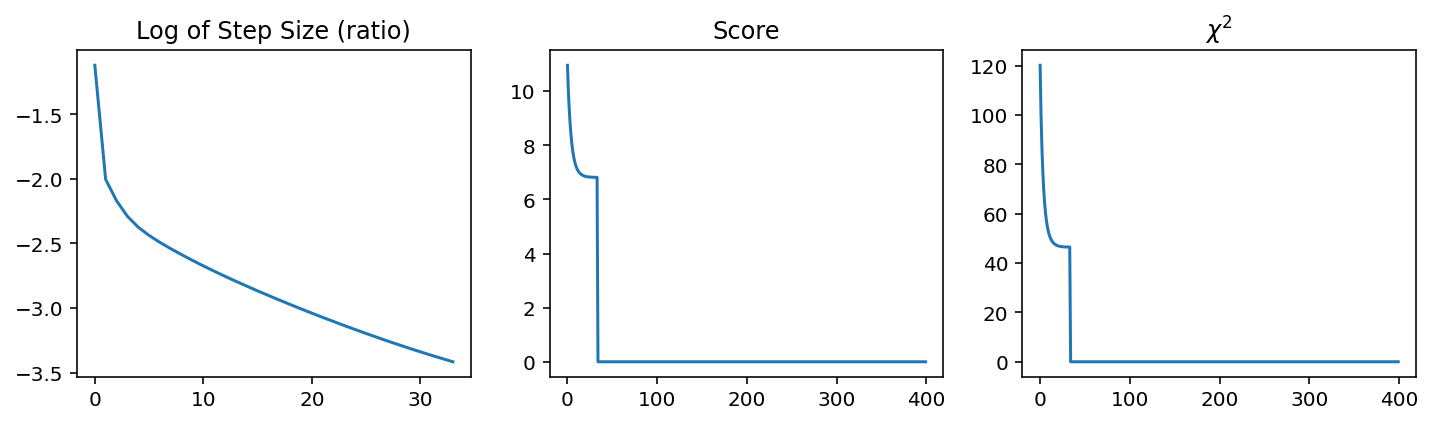

In [157]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

axes[0].plot(np.log10(ratio))
axes[0].set_title("Log of Step Size (ratio)")

axes[1].plot(score)
axes[1].set_title("Score")

axes[2].plot(chisqr)
axes[2].set_title(r"$\chi^2$")

In [135]:
gain_error = np.abs(tgain - garr)/np.abs(tgain)
v_error = (np.abs(valpha - varr)/np.abs(valpha))

In [136]:
print("Gain errors: ", gain_error)
print("Visibility errors: ", v_error)
print("Average errors: ", np.mean(gain_error), np.mean(v_error))

Gain errors:  [0.05956059 0.05670975 0.05708676 0.06332132 0.0649732  0.06202587
 0.05683124 0.05739509 0.08209708 0.07243312 0.06530918 0.06247727
 0.09912627 0.07399122 0.07958335 0.07253134]
Visibility errors:  [0.0892208  0.12882144 0.07891018 0.16320543 0.08041846 0.16956617
 0.16860974 0.10710928 0.0921425  0.17450755 0.08017255 0.09204076
 0.08335541 0.18379928 0.09195916 0.13307758 0.08461829 0.17575449
 0.10163574 0.14897322 0.08344019 0.09478798 0.11972921 0.38693924]
Average errors:  0.067840790410689 0.12969977661456397


In [137]:
title_mod = r"Perturbed $V_\alpha$ and g ($\approx 3$)"

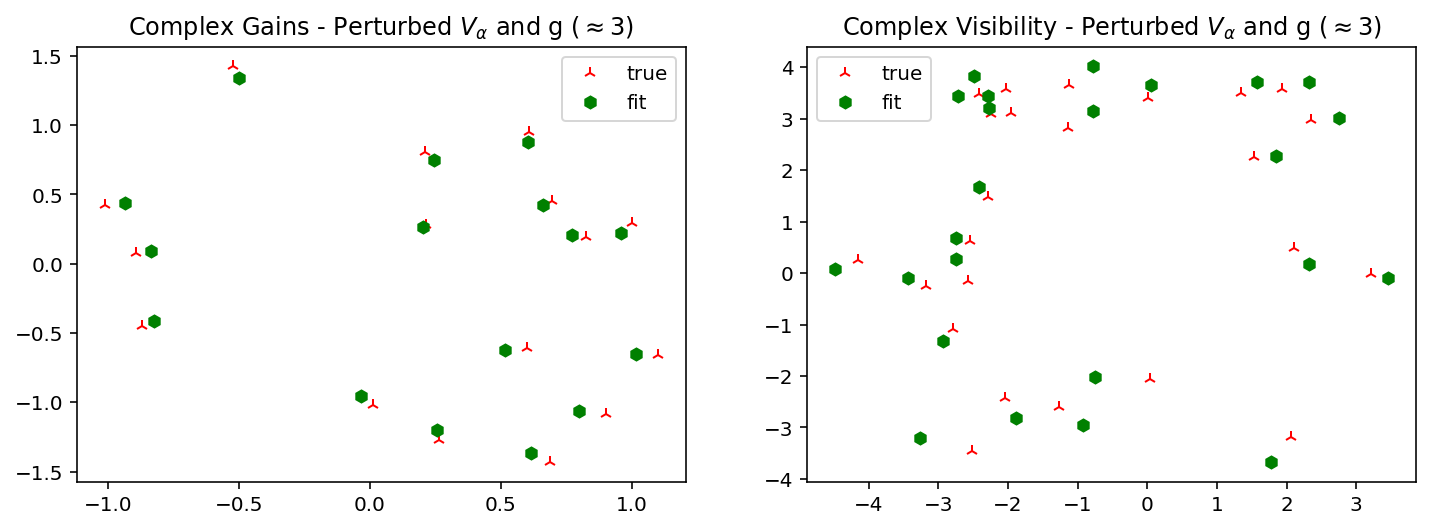

In [138]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(garr.real, garr.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(varr.real, varr.imag, 'gh', label='fit')
axes[1].legend();

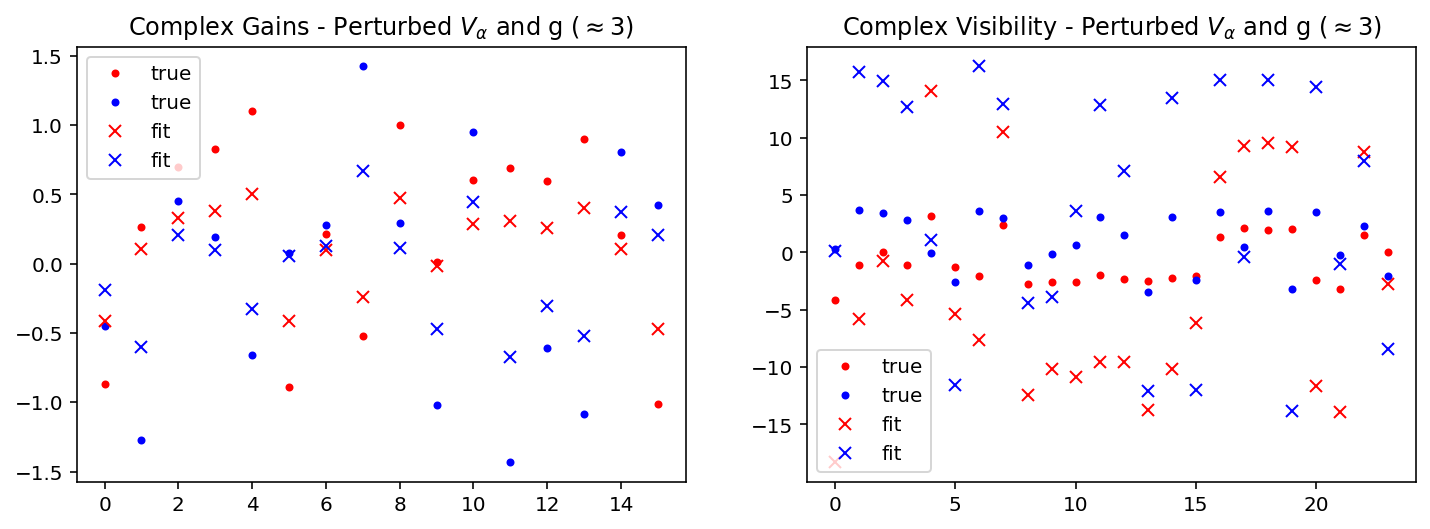

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, 'r.', label='true')
axes[0].plot(tgain.imag, 'b.', label='true')
axes[0].plot(garr.real, 'rx', label='fit')
axes[0].plot(garr.imag, 'bx', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, 'r.', label='true')
axes[1].plot(valpha.imag, 'b.', label='true')
axes[1].plot(varr.real, 'rx', label='fit')
axes[1].plot(varr.imag, 'bx', label='fit')
axes[1].legend();

In [1468]:
telescope_array

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [1466]:
ssr = (observation_baselines[4,5]*observation_baselines[5,7])/(observation_baselines[4,6]*observation_baselines[6,7])

In [1467]:
s = np.sqrt(ssr)

In [1469]:
tsr = (observation_baselines[2,6]*observation_baselines[6,14])/(observation_baselines[2,10]*observation_baselines[10,14])

In [1470]:
t = np.sqrt(tsr)

In [1475]:
np.abs(valpha[0]/valpha[3])

1.097498202012298

In [1476]:
np.abs(observation_baselines[5,6]/observation_baselines[6,10]*1/(s*np.conj(t)))

1.1048564103576697